In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, WhiteKernel, ConstantKernel as C
import pyDOE as doe
from SALib.sample import saltelli
from SALib.analyze import sobol

In [2]:
np.random.seed(10)
##########################################################################################
# sample function -- black box -- would replace w/ experimental data 
##########################################################################################
def func_5D(X):
	# made up function 
	num_pts = X.shape[0]
	y = X[:,0]*5 + X[:,1] + 0.25*np.sin(X[:,2])*X[:,0]**2.0 + np.random.normal(0,2,num_pts) + 100
	return y 


In [3]:
# sample the function (w/ real data this would just be import data)
num_samples = 100
num_variables = 5

lhs_samp = doe.lhs(num_variables, num_samples)

scale_0 = 10; min_0 = 0; max_0 = min_0 + scale_0
scale_1 = 20; min_1 = 3; max_1 = min_1 + scale_1
scale_2 = 2; min_2 = 77; max_2 = min_2 + scale_2
scale_3 = 10; min_3 = 3; max_3 = min_3 + scale_3
scale_4 = 3; min_4 = 2; max_4 = min_4 + scale_4

X = lhs_samp
X[:,0] = X[:,0]*scale_0 + min_0
X[:,1] = X[:,1]*scale_1 + min_1
X[:,2] = X[:,2]*scale_2 + min_2
X[:,3] = X[:,3]*scale_3 + min_3
X[:,4] = X[:,4]*scale_4 + min_4

y = func_5D(X)


In [4]:
# separate data into test and training data
perm = np.random.permutation(num_samples)
num_train = 75
X_train = X[perm[0:num_train],:]
y_train = y[perm[0:num_train]]

X_test = X[perm[num_train:],:]
y_test = y[perm[num_train:]]


In [6]:
# create the model
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
gp = GaussianProcessRegressor(kernel=kernel,alpha=3.0)

# fit the model
gp.fit(X_train, y_train)

# compute the train and test error
y_mean_train, y_std_train = gp.predict(X_train, return_std=True)
y_mean_test, y_std_test = gp.predict(X_test, return_std=True)

test_error = np.mean(np.abs(y_mean_test - y_test))
train_error = np.mean(np.abs(y_mean_train - y_train))
print('test error:',test_error)
print('train error:', train_error)
print('standard deviation of QoI:',np.std(y))

test error: 2.3310423908217826
train error: 1.0513527883723486
standard deviation of QoI: 19.102443217155308


In [8]:
# re-train the model w/ all data available 
gp.fit(X, y)

GaussianProcessRegressor(alpha=3.0, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [9]:
# run SA 
# set up the problem
problem = {
    'num_vars': 5,
    'names': ['x0', 'x1', 'x2', 'x3', 'x4'],
    'bounds': [[min_0, max_0],
               [min_1, max_1],
               [min_2, max_2],
               [min_3, max_3],
               [min_4, max_4]]
}

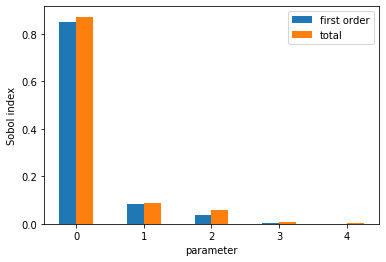

In [13]:
param_values = saltelli.sample(problem, 10000)

# evaluate the model
model_eval = gp.predict(param_values)

# compute sobol indices 
Si = sobol.analyze(problem, model_eval)

first_order = Si['S1']
total = Si['ST']

# plot sobol indices
wid = .25
xax = np.asarray([0,1,2,3,4])

plt.figure()
plt.bar(xax-wid/2.0,first_order,width=wid,label='first order')
plt.bar(xax+wid/2.0,total,width=wid,label='total')
plt.xlabel('parameter')
plt.ylabel('Sobol index')
plt.legend()
plt.savefig('Sobol index')
